In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
#chargement du dataset en utilisant les colonnes 'Jour et Heure' comme index, et la partie P chauffage comme données étudiées
dataset = pd.read_csv("consoPleiades.csv", index_col=['Jour','Heure'])['P Chauffage (W)']

plot1 = dataset.reset_index()['P Chauffage (W)']

In [3]:
def datenumjouran(n,a):
    #Donne la date d=[j,m,a] qui est le nième jour de l'année a
    if ((a%4==0 and a%100!=0) or a%400==0):  # bissextile?
        jm = (0,31,60,91,121,152,182,213,244,274,305,335,366)
    else:
        jm = (0,31,59,90,120,151,181,212,243,273,304,334,365)
    for m in range(1,13):
        if jm[m]>=n:
            return (str(n-jm[m-1])+"/"+str(m)+"/"+str(a))

In [4]:
#assignation de chaque date au jour correspondant des données étudiées
i = 0
DateDataset = []
while i < len(dataset.reset_index()["Jour"]) :
    DateDataset.append(datenumjouran(dataset.reset_index()["Jour"][i],2021) + " - " + str(dataset.reset_index()["Heure"][i])+"h")
    i = i+1

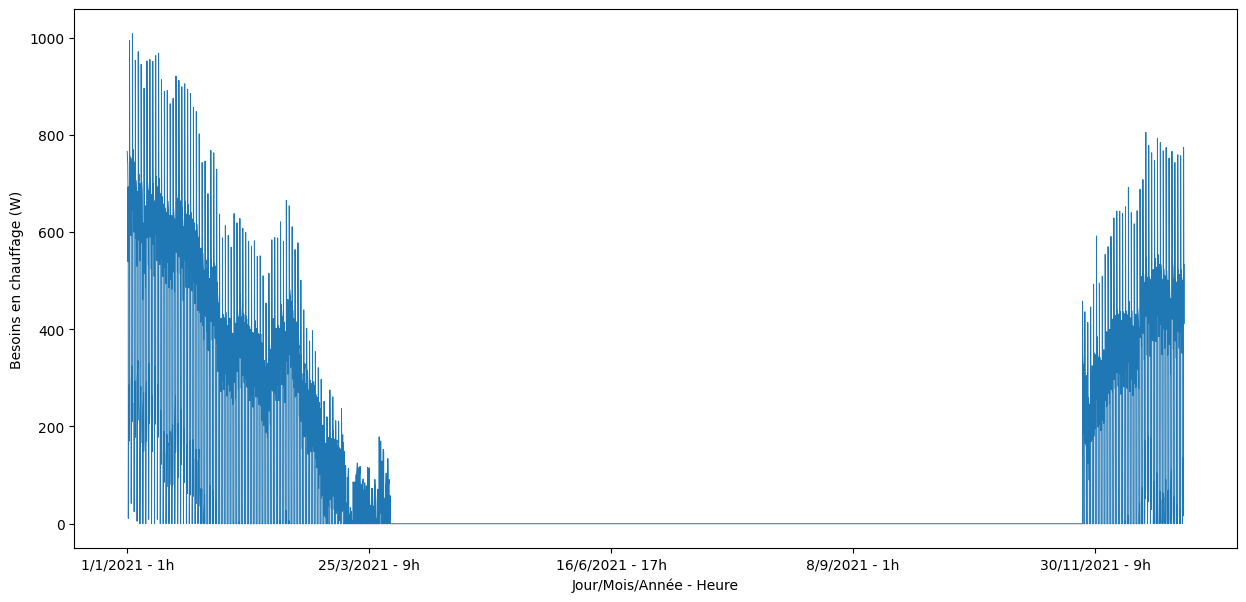

In [5]:
#plot
fig, axes = plt.subplots(1, 1, figsize=(15, 7))
axes.plot(DateDataset, plot1, lw=0.7)
axes.set_ylabel('Besoins en chauffage (W)')
axes.set_xlabel("Jour/Mois/Année - Heure")
axes.xaxis.set_major_locator(MaxNLocator(6))


In [6]:
from scipy import stats

In [7]:
#on vient supprimer les valeurs extrèmes grâce au z_score
def outlier(df):

    z_score = stats.zscore(df)
    filtered = (np.abs(z_score) < 5)
    new_df = df[filtered]

    return new_df

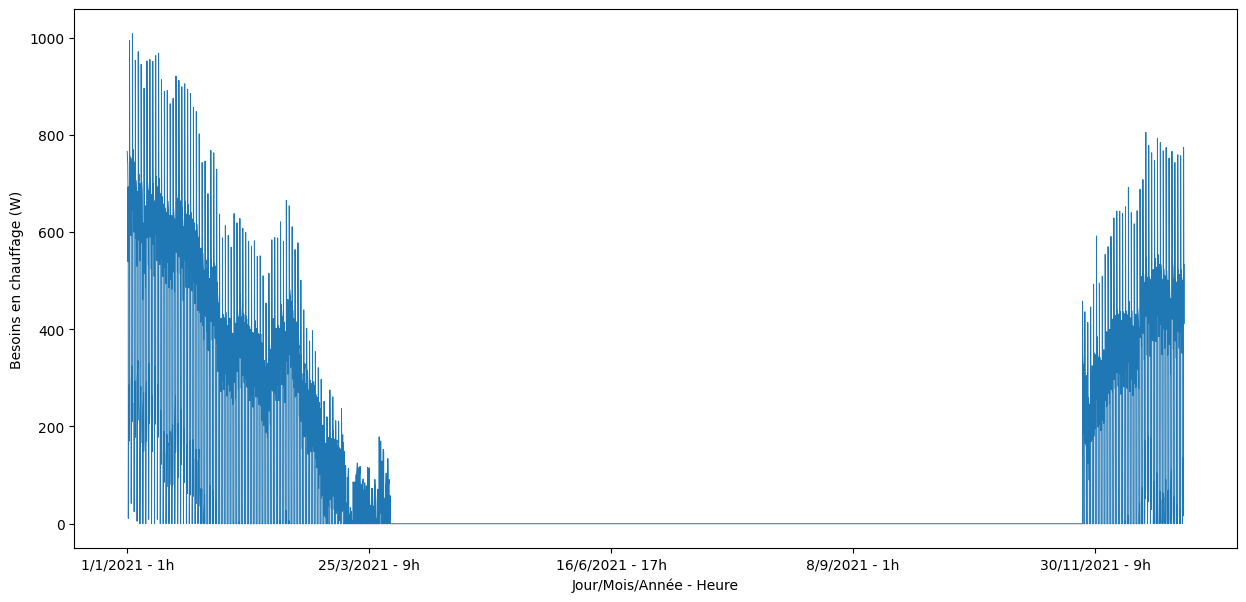

In [8]:
#on applique le lissage
plot2 = outlier(plot1)
#plot du lissage
fig, axes = plt.subplots(1, 1, figsize=(15, 7))
axes.plot(DateDataset, plot2, lw=0.7)
axes.set_ylabel('Besoins en chauffage (W)')
axes.set_xlabel("Jour/Mois/Année - Heure")
axes.xaxis.set_major_locator(MaxNLocator(6))


In [9]:
_min = dataset.min()
_max = dataset.max()

In [10]:
def scale(dataset, _min, _max): #mise à l'échelle de 1 
    new_dataset = ((dataset - _min) / (_max - _min))
    return new_dataset

def unscale(dataset, _min, _max): #mise à l'échelle initiale
    new_dataset = dataset * (_max - _min) + _min
    return new_dataset

In [11]:
#mise à l'échelle des données
dataset_scaled = scale(plot2, _min, _max)

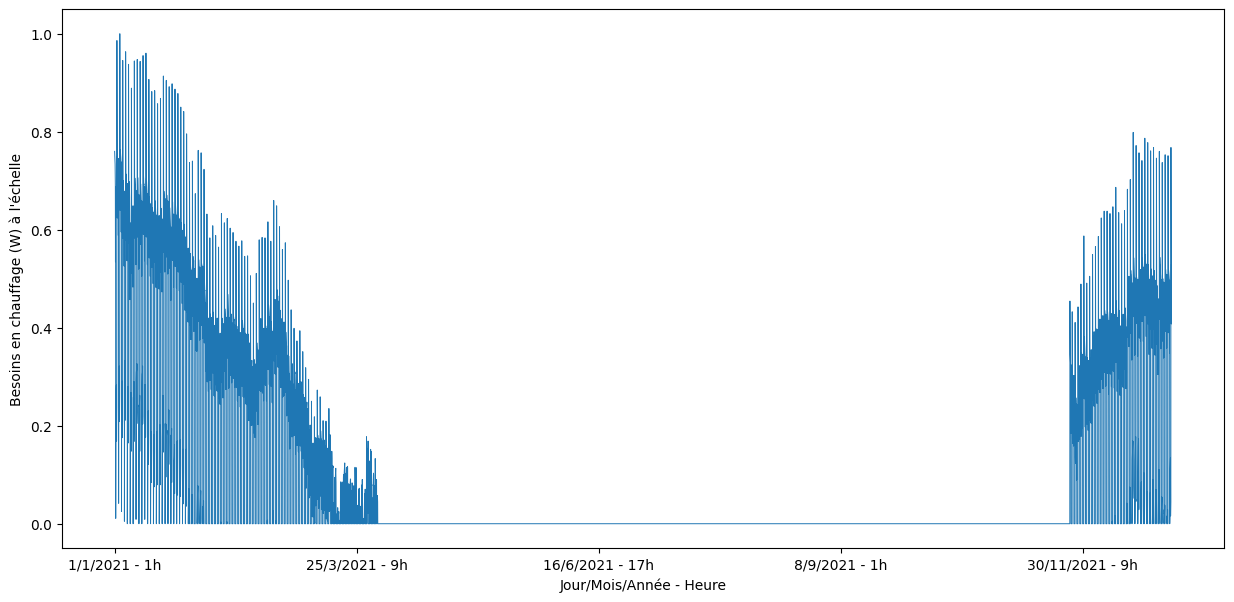

In [12]:
#plot des données mise à l'échelle
fig, axes = plt.subplots(1, 1, figsize=(15, 7))
axes.plot(DateDataset,dataset_scaled, lw=0.7)
axes.set_ylabel('Besoins en chauffage (W) à l\'échelle')
axes.set_xlabel("Jour/Mois/Année - Heure")
axes.xaxis.set_major_locator(MaxNLocator(6))


In [13]:
#définition du taille d'échantillon d'entraînement
size = int(len(dataset) * 0.95)

In [14]:
#taille de la séquence pour chaque méthode
seq_len = 11

## Prédiction : LSTM

In [15]:
#deux séquences, une train à partir de laquelle la méthode va s'entraîner et une autre qui sera la partie des valeurs prédites
#propre aux séries temporelles
trainGenerator = TimeseriesGenerator(dataset_scaled[:size].to_numpy(), dataset_scaled[:size].to_numpy(), length=seq_len)
testGenerator = TimeseriesGenerator(dataset_scaled[size:].to_numpy(), dataset_scaled[size:].to_numpy(), length=seq_len)

In [16]:
#import du modèle LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, InputLayer

In [17]:
#initialisation du modèle LSTM à l'aide de tensorflow
def createSimpleLSTM():
    model = Sequential()
    model.add(InputLayer(input_shape=(seq_len, 1)))
    model.add(LSTM(units=100))
    model.add(Dense(units=1))
    model.compile(optimizer='rmsprop', loss='mse')
    
    return model

In [18]:
#création du moèdle puis entraînement
model = createSimpleLSTM()
model.fit(trainGenerator, epochs=10, batch_size=128)

Epoch 1/10
65/65 [==============================] - 5s 25ms/step - loss: 0.0251
Epoch 2/10
65/65 [==============================] - 2s 24ms/step - loss: 0.0125
Epoch 3/10
65/65 [==============================] - 2s 25ms/step - loss: 0.0093
Epoch 4/10
65/65 [==============================] - 2s 25ms/step - loss: 0.0085
Epoch 5/10
65/65 [==============================] - 2s 26ms/step - loss: 0.0081
Epoch 6/10
65/65 [==============================] - 2s 25ms/step - loss: 0.0078
Epoch 7/10
65/65 [==============================] - 2s 25ms/step - loss: 0.0075
Epoch 8/10
65/65 [==============================] - 2s 25ms/step - loss: 0.0072
Epoch 9/10
65/65 [==============================] - 2s 25ms/step - loss: 0.0071
Epoch 10/10
65/65 [==============================] - 2s 25ms/step - loss: 0.0070


In [19]:
#génération de la prédiction
prediction = model.predict(testGenerator)

4/4 [==============================] - 1s 11ms/step


In [20]:
#assignation des dates correspondantes
i = 0
DateDatasetSized = []
while i < len(dataset[size+11:].reset_index()["Jour"]) :
    DateDatasetSized.append(datenumjouran(dataset[size+11:].reset_index()["Jour"][i],2021) + " - " + str(dataset[size+11:].reset_index()["Heure"][i])+"h")
    i = i+1

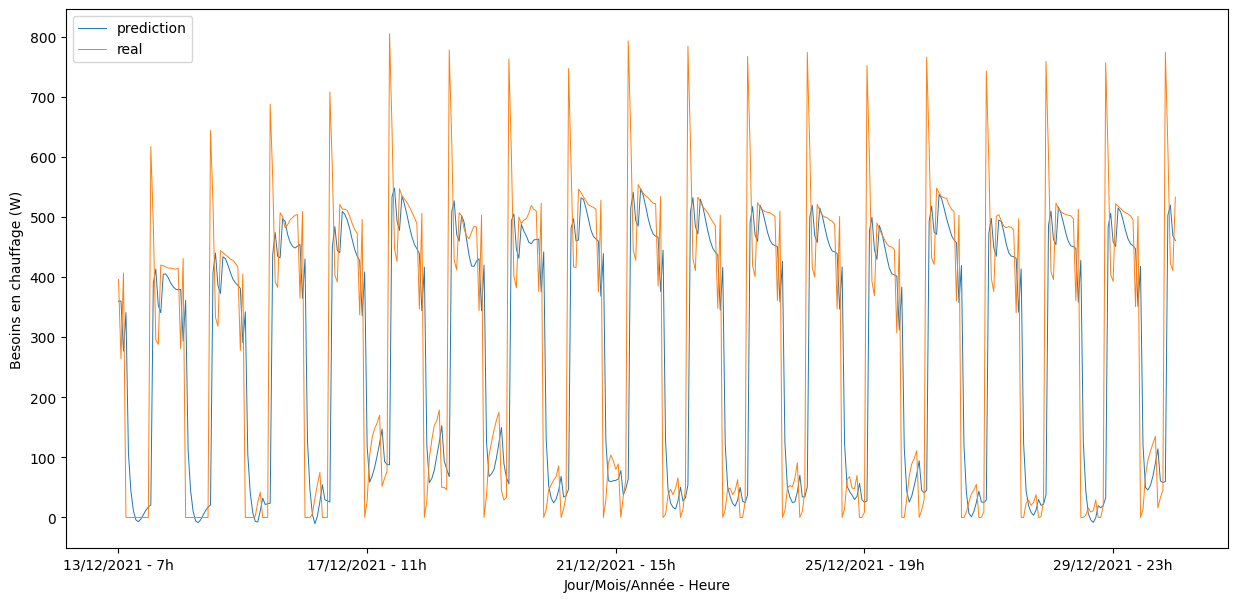

In [21]:
#plot de la comparaison entre la prédiction et la réalité
fig, axes = plt.subplots(1, 1, figsize=(15, 7))
axes.plot(DateDatasetSized, unscale(prediction,_min,_max), lw=0.7, label='prediction')
axes.plot(DateDatasetSized, unscale(dataset_scaled[size+11:].to_numpy(),_min,_max), lw=0.7, label='real')
axes.set_ylabel('Besoins en chauffage (W)')
axes.set_xlabel("Jour/Mois/Année - Heure")
axes.xaxis.set_major_locator(MaxNLocator(5))
axes.legend()

In [22]:
#calcul de l'erreur moyenne
np.sqrt(mean_squared_error(prediction, dataset_scaled[size:].to_numpy()[11:]))

0.17745649598619048

## Prédiction : RandomForestRegressor

In [23]:
#création du dataset cible et test
def create_dataset(dataset, seq_len):
    dataX, dataY = [], []
    for i in range(len(dataset)-seq_len-1):
        a = dataset[i:(i + seq_len)]
        dataX.append(a)
        dataY.append(dataset[i + seq_len])
    return np.array(dataX), np.array(dataY)

In [24]:
dataX, dataY = create_dataset(dataset_scaled[:size].to_numpy(), seq_len)
testX, testY = create_dataset(dataset_scaled[size:].to_numpy(), seq_len)

In [25]:
from sklearn.ensemble import RandomForestRegressor

In [26]:
#partie à commenter si on ne veut pas faire d'étude
tabPrecision = []
col = []
row = []
Pr_max=0
n_max = 0
depth_max=0
best_prediction = prediction

#paramétrage étude de la précision en fonction des paramètres
sup_n = 14
sup_depth = 14
nbsimul=20

for i in range(1,sup_n+1) : #paramètre nb d'arbres
    print("étude... arbre " + str(i)+"/"+str(sup_n))
    col.append(i)
    tabTemp=[]
    for j in range(1,sup_depth+1) : #paramètre profondeurs d'arbres
        if not j in row:
            row.append(j)
        total=0
        moyenne=0
        for nb in range(1,nbsimul+1): #test de chaque combinaison 
            model = RandomForestRegressor(n_estimators=i, max_depth=j)
            model.fit(dataX, dataY)
            prediction = model.predict(testX)
            precision = 100-100*np.sqrt(mean_squared_error(prediction, testY))
            total += precision
        moyenne=total/nbsimul
        if moyenne>=Pr_max : #sauvegarde des meilleurs paramètres
            Pr_max=moyenne
            n_max=i
            depth_max=j
            best_prediction=prediction
        tabTemp.append(moyenne)
    tabPrecision.append(tabTemp)
print("étude finie !")
dfprecision = pd.DataFrame(tabPrecision, index = row, columns = col) #création du dataframe stockant chaque valeur

étude... arbre 1/14
étude... arbre 2/14
étude... arbre 3/14
étude... arbre 4/14
étude... arbre 5/14
étude... arbre 6/14
étude... arbre 7/14
étude... arbre 8/14
étude... arbre 9/14
étude... arbre 10/14
étude... arbre 11/14
étude... arbre 12/14
étude... arbre 13/14
étude... arbre 14/14
étude finie !


In [27]:
dfprecision.style.background_gradient(cmap='Greens')

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1,80.944098,80.673441,83.372253,86.195537,87.086843,87.699898,89.286212,90.126944,89.932218,90.145912,89.274335,90.163512,92.060962,89.500865
2,81.047801,81.222987,85.702313,87.764793,89.925715,91.541145,91.308512,92.183015,92.285540,92.510200,91.535120,92.164252,92.807897,91.803265
3,81.117574,81.448464,85.639802,89.317427,90.818853,91.570432,91.500485,92.832951,93.378676,93.368828,93.289682,93.634978,92.996761,93.658166
4,81.071793,81.851663,84.871369,89.477213,92.366653,92.609479,92.736179,93.539710,92.190299,93.552851,93.321108,93.186084,93.367671,93.498350
5,81.085930,81.603696,85.737645,89.626404,91.579153,93.174051,92.359075,92.836360,93.636835,92.862590,94.619108,92.946710,92.840475,93.750626
6,81.109462,81.691792,85.784077,89.715108,92.361141,91.838459,93.035706,93.232550,93.731927,93.380294,92.675708,93.690313,94.112570,93.082182
7,81.090500,81.727868,85.444642,89.398735,91.655923,92.925871,92.896233,93.480266,94.222838,93.761362,93.724512,93.329680,94.426563,93.760510
8,81.143634,81.791281,86.117419,90.472685,92.145597,93.557739,93.406095,94.224076,93.916250,93.887542,94.523633,94.036928,93.890942,94.078314
9,81.085903,81.623762,85.778151,89.813936,92.313763,93.108489,93.094425,94.339672,94.116254,93.800349,93.241446,93.803862,93.224324,93.811771
10,81.095461,81.850641,85.793195,89.880529,92.049897,92.898219,93.534132,93.641223,94.344784,93.958039,93.698919,94.244119,94.371130,94.059312


In [28]:
i = 0
DateDatasetSized = []
while i < len(dataset[size+12:].reset_index()["Jour"]) :
    DateDatasetSized.append(datenumjouran(dataset[size+12:].reset_index()["Jour"][i],2021) + " - " + str(dataset[size+12:].reset_index()["Heure"][i])+"h")
    i = i+1

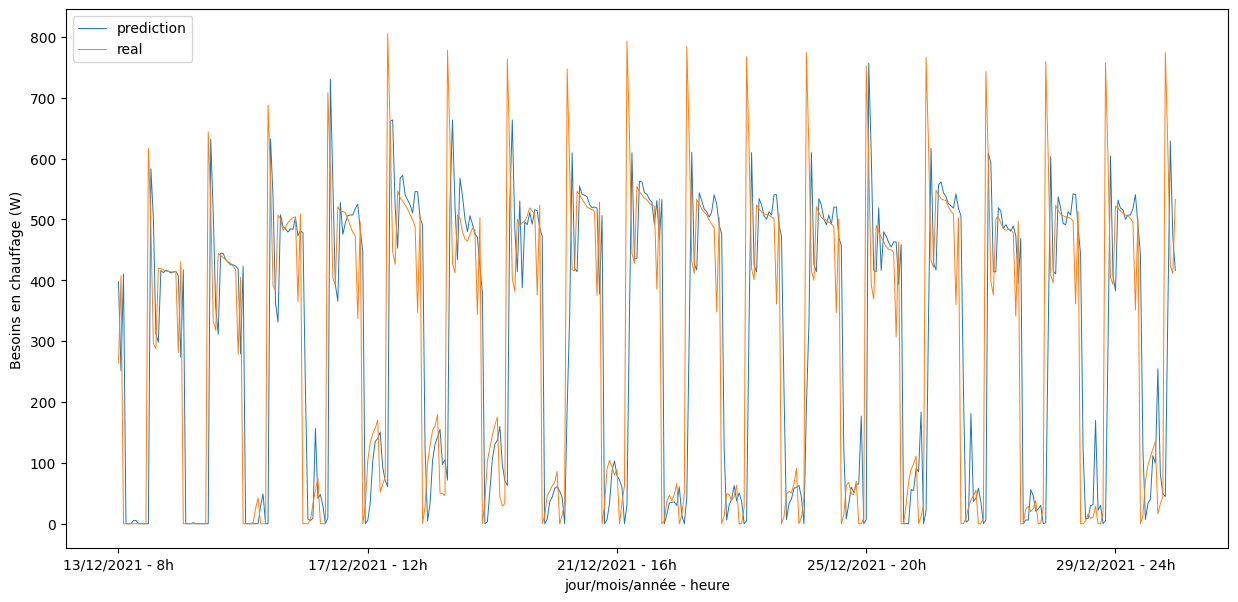

In [29]:
fig, axes = plt.subplots(1, 1, figsize=(15, 7))
axes.plot(DateDatasetSized, unscale(best_prediction,_min,_max), lw=0.7, label='prediction')
axes.plot(DateDatasetSized, unscale(dataset_scaled[size+12:].to_numpy(),_min,_max), lw=0.7, label='real')
axes.set_ylabel('Besoins en chauffage (W)')
axes.set_xlabel("jour/mois/année - heure")
axes.xaxis.set_major_locator(MaxNLocator(5))
axes.legend()

In [30]:
np.sqrt(mean_squared_error(best_prediction, testY))

0.07983452026120137